# ***The influence of landslides on gravel-bed river network evolution***
### CSDMS ESPIn 2024: Event-Sediment-Pluse Team
Contributers (listed in the aphabetic order of last name): 
- Nilay Iscen
- John Kemper
- Larry Syu-Heng Lai
- Yuan Li

___
___

## Introduction

Landslides are the main sources of sediments to the river network in mountainous regions. In this lab, we will explore the response of river network to a sudden sediment supply increase through interactions between the landslide sediment delivery and fluvial transport.

In this notebook, to achieve this analysis throught the following steps:
* Step 1: Setup an steady-state initial landscape before catastropic landslide event
    * Run simulation using SPACE
    * Show the landform, sediment thickness, and river long-profile

* Step 2: Hit a 20-year-long catastrophic landslide "event" to the landscape
    * Run simulation using Hyland (BedrockLandsider) for 20 years
    * Show the landform, sediment thickness, and river long-profile

* Step 3: See how landslide-derived sediments affect the evolution of downstream channels.
    * Run simulation using GravelBedrockEroder for 20 years
    * Plot changing landform/profile, soil thickness of each time step (every year)

## Model information
### SPACE (Stream Power with Alluvium Conservation and Entrainment): 

The **SPACE** component is a model that simulates...

For details about the **SPACE** component in Landlab:  

https://landlab.readthedocs.io/en/master/reference/components/space.html 

Reference:

Shobe, C. M., Tucker, G. E., and Barnhart, K. R.: The SPACE 1.0 model: a Landlab component for 2-D calculation of sediment transport, bedrock erosion, and landscape evolution, Geosci. Model Dev., 10, 4577-4604, https://doi.org/10.5194/gmd-10-4577-2017, 2017. 

### HyLands:

The **Hyland** component is ...

Reference:

Campforts, B., Shobe, C. M., Steer, P., Vanmaercke, M., Lague, D., and Braun, J.: HyLands 1.0: a hybrid landscape evolution model to simulate the impact of landslides and landslide-derived sediment on landscape evolution, Geosci. Model Dev., 13, 3863–3886, https://doi.org/10.5194/gmd-13-3863-2020, 2020.

### Landlab components:

In this lab, we will also utilize the **GravelBedrockEroder**, **BedrockLandslider**, **FlowAccumulator** and **DepressionFinderAndRouter** components. 

**GravelBedrockEroder** is ...
**FlowAccumulator** calculates ...


More info can be found here:  

https://landlab.readthedocs.io/en/master/reference/components/flow_accum.html 

https://landlab.readthedocs.io/en/master/reference/components/flow_routing.html 



#### Description of River Longitudinal Profiles
The impact of fires

### Other things to mention:

More here.. maybe

<hr>

### Importing necessary libraries and components:

In [1]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt  # For plotting results; optional
import numpy as np

from landlab import RasterModelGrid  # Grid utility
from landlab import imshow_grid, imshowhs_grid  # For plotting results; optional
from landlab.components import BedrockLandslider  # BedrockLandslider model
from landlab.components import SpaceLargeScaleEroder  # SPACE model
from landlab.components import PriorityFloodFlowRouter
from landlab.components import FlowAccumulator, GravelBedrockEroder # GBE model
from landlab.components import ChannelProfiler # channel profiles with sediment
from plt_topo_ntwk_soildepth import plt_landscape_evo # just a function for plotting repeated results: topo, channel network, soil depth
import pickle # For saving and loading landlab grid object 

<hr>

### STEP 1: **Creating a synthetic initial steady-state landscape:**
Here, we will define the model domain and set the parameters to create a synthetic landscape using **SPACE**, **PriorityFloodFlowRouter**

### Instantiating the model grid:

Here, we instantiate the model grid, and set the boundary conditions.

The bottom left corner is the watershed outlet, which is set as an open boundary condition to allow flux out. 
All other boundary nodes are closed. 

Creating fields.

More here..

In [2]:
# Create initial model topography:

# Set model grid shape and size
num_rows = 30
num_columns = 30
node_spacing = 25.0

# Instantiate model grid
mg = RasterModelGrid((num_rows, num_columns), node_spacing) 
mg.add_zeros("node", "topographic__elevation") # add field ’topographic elevation’ to the grid
# add topographic roughness
random_noise = (np.random.rand(len(mg.node_y)) / 1000.0)  # impose topography values on model grid
mg["node"]["topographic__elevation"] += random_noise

mg.add_zeros("node", "soil__depth") # Create a field 'soil__depth' to the grid
mg.at_node["soil__depth"][mg.core_nodes] = 1.0  #Set s m of initial soil depth at core nodes

# Add field 'bedrock__elevation' to the grid
mg.add_zeros("bedrock__elevation", at="node")

# Yield 'topographic elevation' by summing 'soil__depth' and 'bedrock__elevation'
mg.at_node["bedrock__elevation"][:] = mg.at_node["topographic__elevation"]
mg.at_node["topographic__elevation"][:] += mg.at_node["soil__depth"]

# Close all model boundary edges except the node #5, allowing only one outlet
mg.set_closed_boundaries_at_grid_edges(
    bottom_is_closed=True,
    left_is_closed=True,
    right_is_closed=True,
    top_is_closed=True,
)
mg.status_at_node[5] = 1 

### Instantiating model components for the initial landscape:

Here we instantiate the **PriorityFloodFlowRouter** and **BedrockLandslider**..

In [3]:
# Instantiate flow router
fr = PriorityFloodFlowRouter(mg, flow_metric="D8", suppress_out=True)

# Instantiate SPACE model with chosen parameters
sp = SpaceLargeScaleEroder(
    mg,
    K_sed=2.5e-5,
    K_br=2.5e-5,
    F_f=0.0,
    phi=0.0,
    H_star=1.0,
    v_s=1,
    m_sp=0.5,
    n_sp=1.0,
    sp_crit_sed=0,
    sp_crit_br=0,
)

### Run SPACE to generate the initial semi-steady-state landscape
We use/iterate the **SPACE** through a time loop to evolve the landscape to a steady state before adding landslide component.

In [4]:
# Set model parameters
timestep = 500       # timestep in years
elapsed_time = 0.0   # Set elapsed time to zero
count = 0            # Set timestep count to zero
run_time = 500000    # Set model run time
U = 0.02             # Uplift rate in m/yr
sed_flux = np.zeros(int(run_time // timestep)) # Array to save sediment flux values

cmap = copy.copy(mpl.colormaps["terrain"])  # Define the color map for elevation

while elapsed_time < run_time:  # time units of years
    # Insert uplift at core nodes
    mg.at_node["bedrock__elevation"][mg.core_nodes] += U * timestep
    mg.at_node["topographic__elevation"][:] = (
        mg.at_node["bedrock__elevation"] + mg.at_node["soil__depth"]
    )

    # Run the flow router
    fr.run_one_step()

    # Run SPACE for one time step
    sp.run_one_step(dt=timestep)

    # Add to value of elapsed time
    elapsed_time += timestep

    if np.mod(elapsed_time, 1e5) == 0:
        print("%.2f of model run completed" % (elapsed_time / run_time))

0.20 of model run completed
0.40 of model run completed
0.60 of model run completed
0.80 of model run completed
1.00 of model run completed


##### Export pre-landslide initial landscape landlab grid object as a pickle file

In [5]:
# Exporting landlab grid object
with open('pre-slide_fakelandscape.pickle', 'wb') as f:
    pickle.dump(mg, f)

In [6]:
# If we want to import other pickle file of landlab grid object
# with open('pre-slide_fakelandscape.pickle', 'rb') as g:
#     mg = pickle.load(g)

### Plotting drainage network, river profile, and other attributes

##### Plot landscape, soildepth, and plane-view river network (Yuan Li)

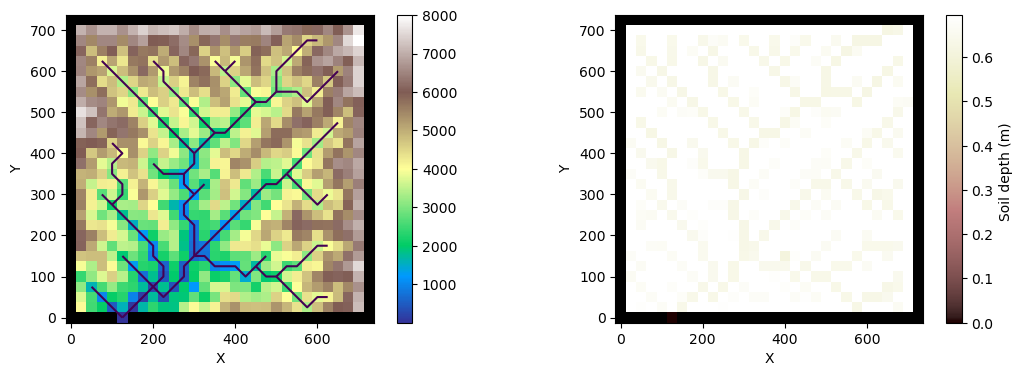

In [7]:
# Derive river network using ChannelProfiler
dx = node_spacing
area_threshold = dx*dx*10.
profiler = ChannelProfiler(mg, number_of_watersheds=1, minimum_channel_threshold=area_threshold, main_channel_only=False)
profiler.run_one_step()


####### Start plotting #######
plt_landscape_evo(profiler,mg)

#### Plot long-river profile and other info (Nilay)
##### ***Inspired by Dr. Susannah Morey's unpublished works***

(0.0, 8812.439884570844)

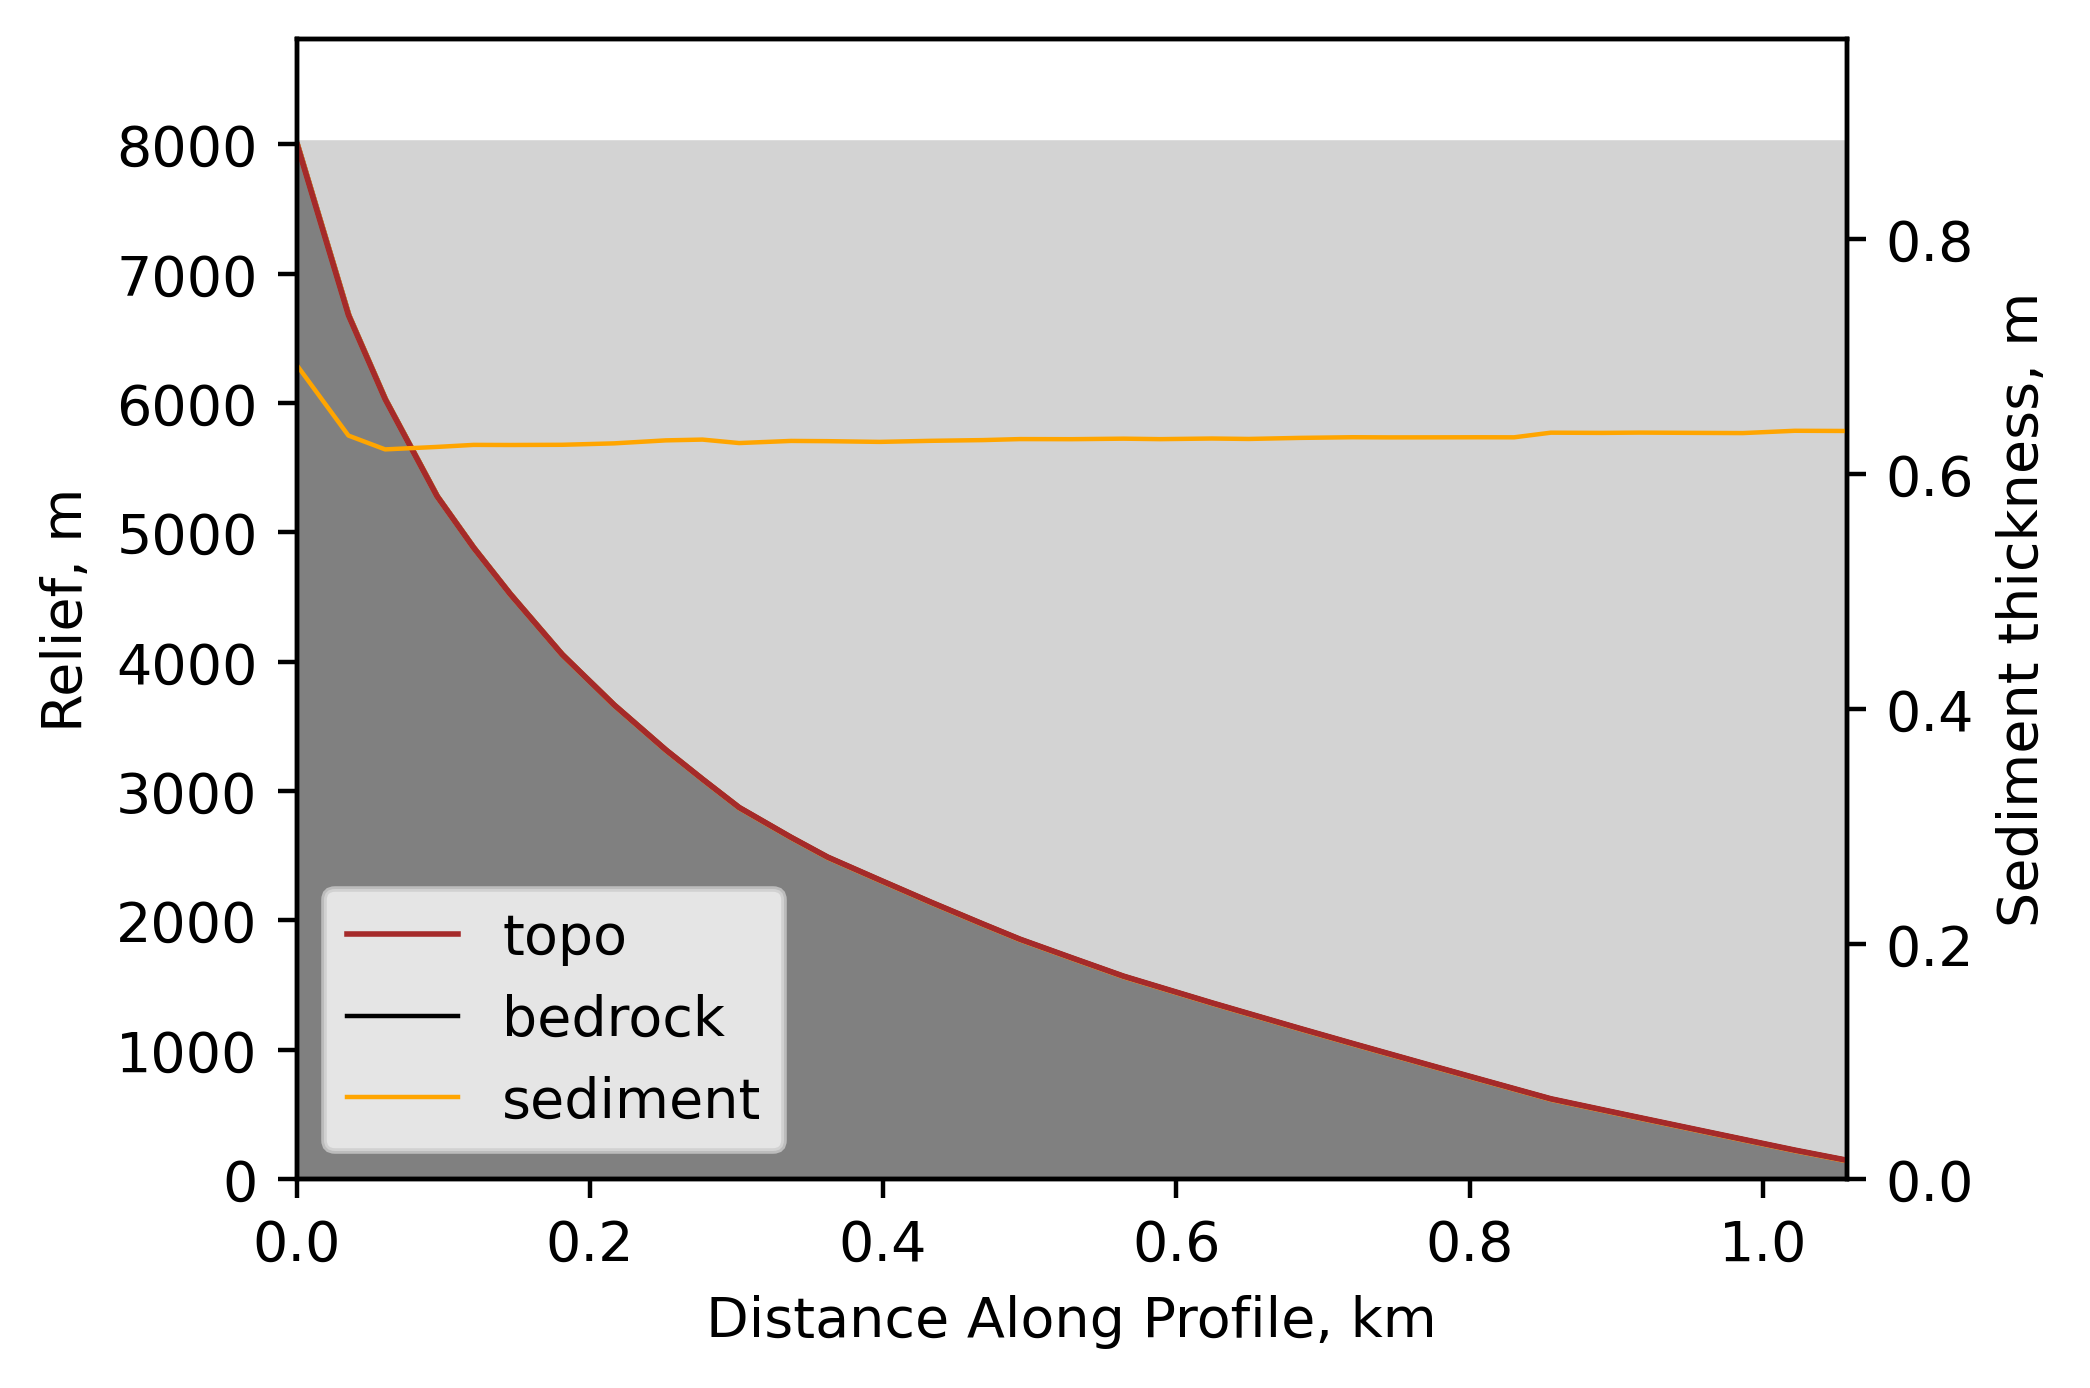

In [8]:
profiler = ChannelProfiler(mg)
profiler.run_one_step()
riv_nodes = profiler.nodes

mg.at_node["bedrock_elevation"]=mg.at_node["topographic__elevation"]-mg.at_node["soil__depth"]
dist_atNodes=profiler.distance_along_profile[0]

el = mg.at_node["topographic__elevation"][riv_nodes]
sd = mg.at_node["soil__depth"][riv_nodes]

br = el-sd     # Use ravel() to flatten el and br to 1D
el = el.ravel()
sd = sd.ravel()
br = br.ravel() # Calculate minimum elevation and relief

min_elevation = min(np.min(el), np.min(br), 0)
el_relief = el - min_elevation
br_relief = br - min_elevation

qs = mg.at_node["sediment__flux"][riv_nodes]
qs[np.where(qs<10)] = np.nanplt_fontsize =10     

fig, ax1 = plt.subplots(figsize=(5,3.7), dpi=400)
ax2 = ax1.twinx()

dist = (max(dist_atNodes)-dist_atNodes)*1e-3 
brown_c = [205/255,133/255,63/255] # Fill the entire area from max relief to 0

ax1.fill_between(dist, np.max(el_relief), 0, color='lightgrey', label='total area') # Fill the bedrock and colluvial material relief
ax1.fill_between(dist, br_relief, 0, color='grey', label='bedrock')
ax1.fill_between(dist, el_relief, br_relief, color=brown_c, label='colluvial material') # Plot bedrock and topographic relief

lns2 = ax1.plot(dist, br_relief, color='k', label='bedrock', linewidth=0.8, zorder=3)
lns1 = ax1.plot(dist, el_relief, color='brown', label='topo', linewidth=1, zorder=4) # set up labels

ax1.set_xlabel('Distance Along Profile, km', fontweight='normal', fontsize=10.0)
ax1.tick_params(labelsize=10.0)
ax1.set_ylabel('Relief, m', fontweight='normal', fontsize=10.0)
ax1.set_ylim((0, np.max(el_relief)*1.1))


# plot sediment thickness
lns3 = ax2.plot(dist, sd, color='orange', label ='sediment', linewidth=0.8)

ax2.set_ylabel('Sediment thickness, m', fontweight='normal', fontsize=10.0)
ax2.set_ylim((0, np.nanmax(sd)*1.4))
ax2.set_xlim((0, dist[2]))
ax2.tick_params(labelsize=10.0) # Merge legends

lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]

ax1.legend(lns, labs, fontsize=10.0) # Set y-axis to start from 0
ax1.set_ylim(bottom=0)

<hr>

## STEP 2: **Hit the catastrophic landslide event to the landscape:**
### Run the Hyland (Bedrocklandslider) to the steady-state landscape for 20 years:

Initialize the flow director and SPACE and BedrockLandslider components

In [9]:
# Instantiate flow router, with additional multiple flow director for hillslopes
fr = PriorityFloodFlowRouter(
    mg,
    flow_metric="D8",
    separate_hill_flow=True,
    hill_flow_metric="Quinn",
    update_hill_flow_instantaneous=True,
)

# Instantiate SPACE model with chosen parameters
hy = BedrockLandslider(
    mg,
    angle_int_frict=0.4,
    cohesion_eff=1e3,
    landslides_return_time=1000,
    landslides_on_boundary_nodes=False,
)

Run the time loop over 20 years to develop a landscape with landslide activities

In [10]:
# Reset elevation back to elevation simulated without landslides to test various landslide configuration settings
# z_before_LS = np.array(mg["node"]["topographic__elevation"])
# mg["node"]["topographic__elevation"][:] = z_before_LS

timestep = 1  # years
landslides_size_all_steps = []

for i in range(20):
    # Insert uplift at core nodes
    mg.at_node["bedrock__elevation"][mg.core_nodes] += U * timestep
    mg.at_node["topographic__elevation"][:] = (
        mg.at_node["bedrock__elevation"] + mg.at_node["soil__depth"]
    )

    # Run the flow router
    #fr.run_one_step()

    # Run SPACE for one time step
    #sp.run_one_step(dt=timestep)

    # Run BedrockLandslider for one time step
    hy.run_one_step(dt=timestep)

    # Store landslide sizes of current time step into general ls_size list
    landslides_size_all_steps = np.append(landslides_size_all_steps, hy.landslides_size)

Export post-landslide landscape landlab grid object as a pickle file

In [11]:
# Exporting landlab grid object
with open('post-slide_fakelandscape.pickle', 'wb') as f:
    pickle.dump(mg, f)

In [12]:
# If we want to import other pickle file of landlab grid object
# with open('post-slide_fakelandscape.pickle', 'rb') as g:
#     mg = pickle.load(g)

##### Plot post-landslide landscape, soildepth, and plane-view river network etc (Yuan Li)

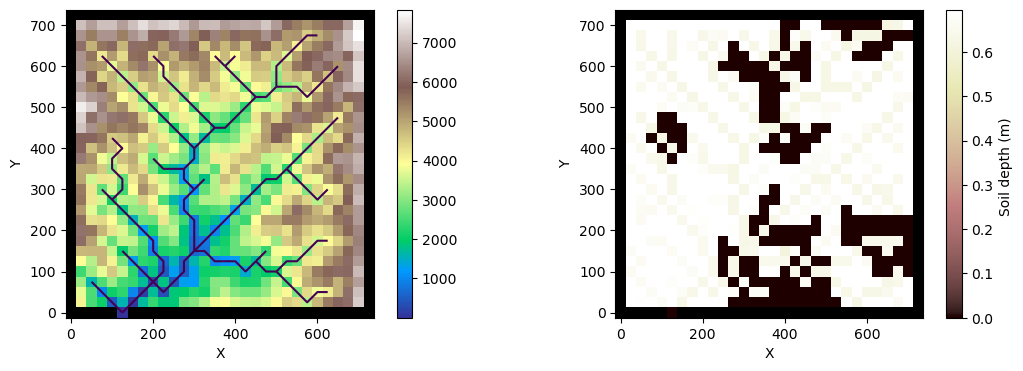

In [13]:
# Derive river network using ChannelProfiler
dx = node_spacing
area_threshold = dx*dx*10.
profiler = ChannelProfiler(mg, number_of_watersheds=1, minimum_channel_threshold=area_threshold, main_channel_only=False)
profiler.run_one_step()


####### Start plotting #######
plt_landscape_evo(profiler,mg)

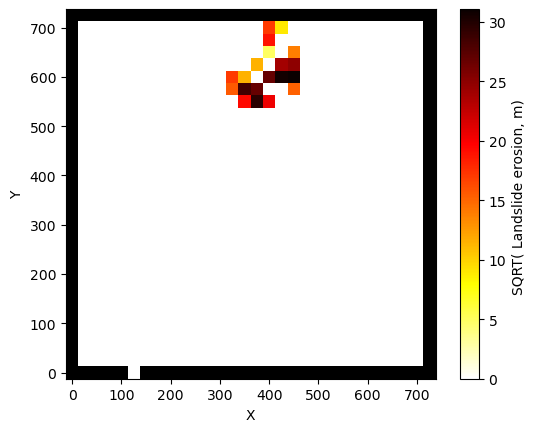

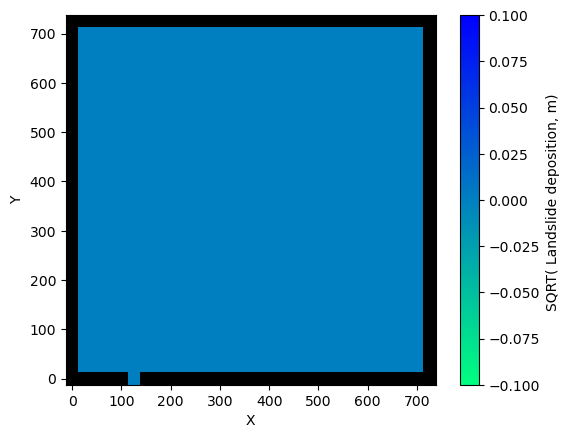

In [14]:
# Landslide Erosion
cmap = copy.copy(mpl.colormaps["hot_r"])
imshow_grid(
    mg,
    np.sqrt(mg.at_node["landslide__erosion"]),
    colorbar_label="SQRT( Landslide erosion, m) ",
    cmap=cmap,
)
plt.show()

# Landslide Deposition
cmap = copy.copy(mpl.colormaps["winter_r"])
imshow_grid(
    mg,
    np.sqrt(mg.at_node["landslide__deposition"]),
    colorbar_label="SQRT( Landslide deposition, m) ",
    cmap=cmap,
)
plt.show()

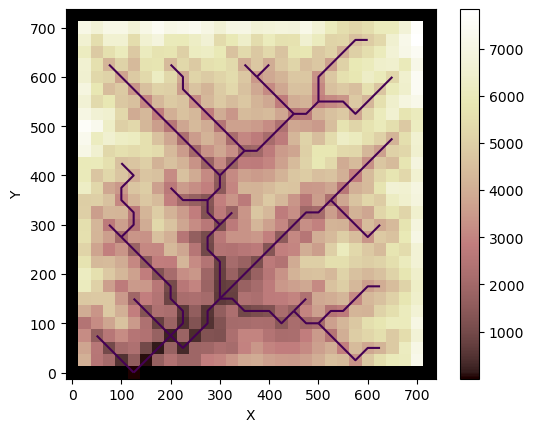

In [15]:
profiler.plot_profiles_in_map_view()

##### Plot river profile and other info for post-landslide landscape (Nilay)

(0.0, 8622.606599432524)

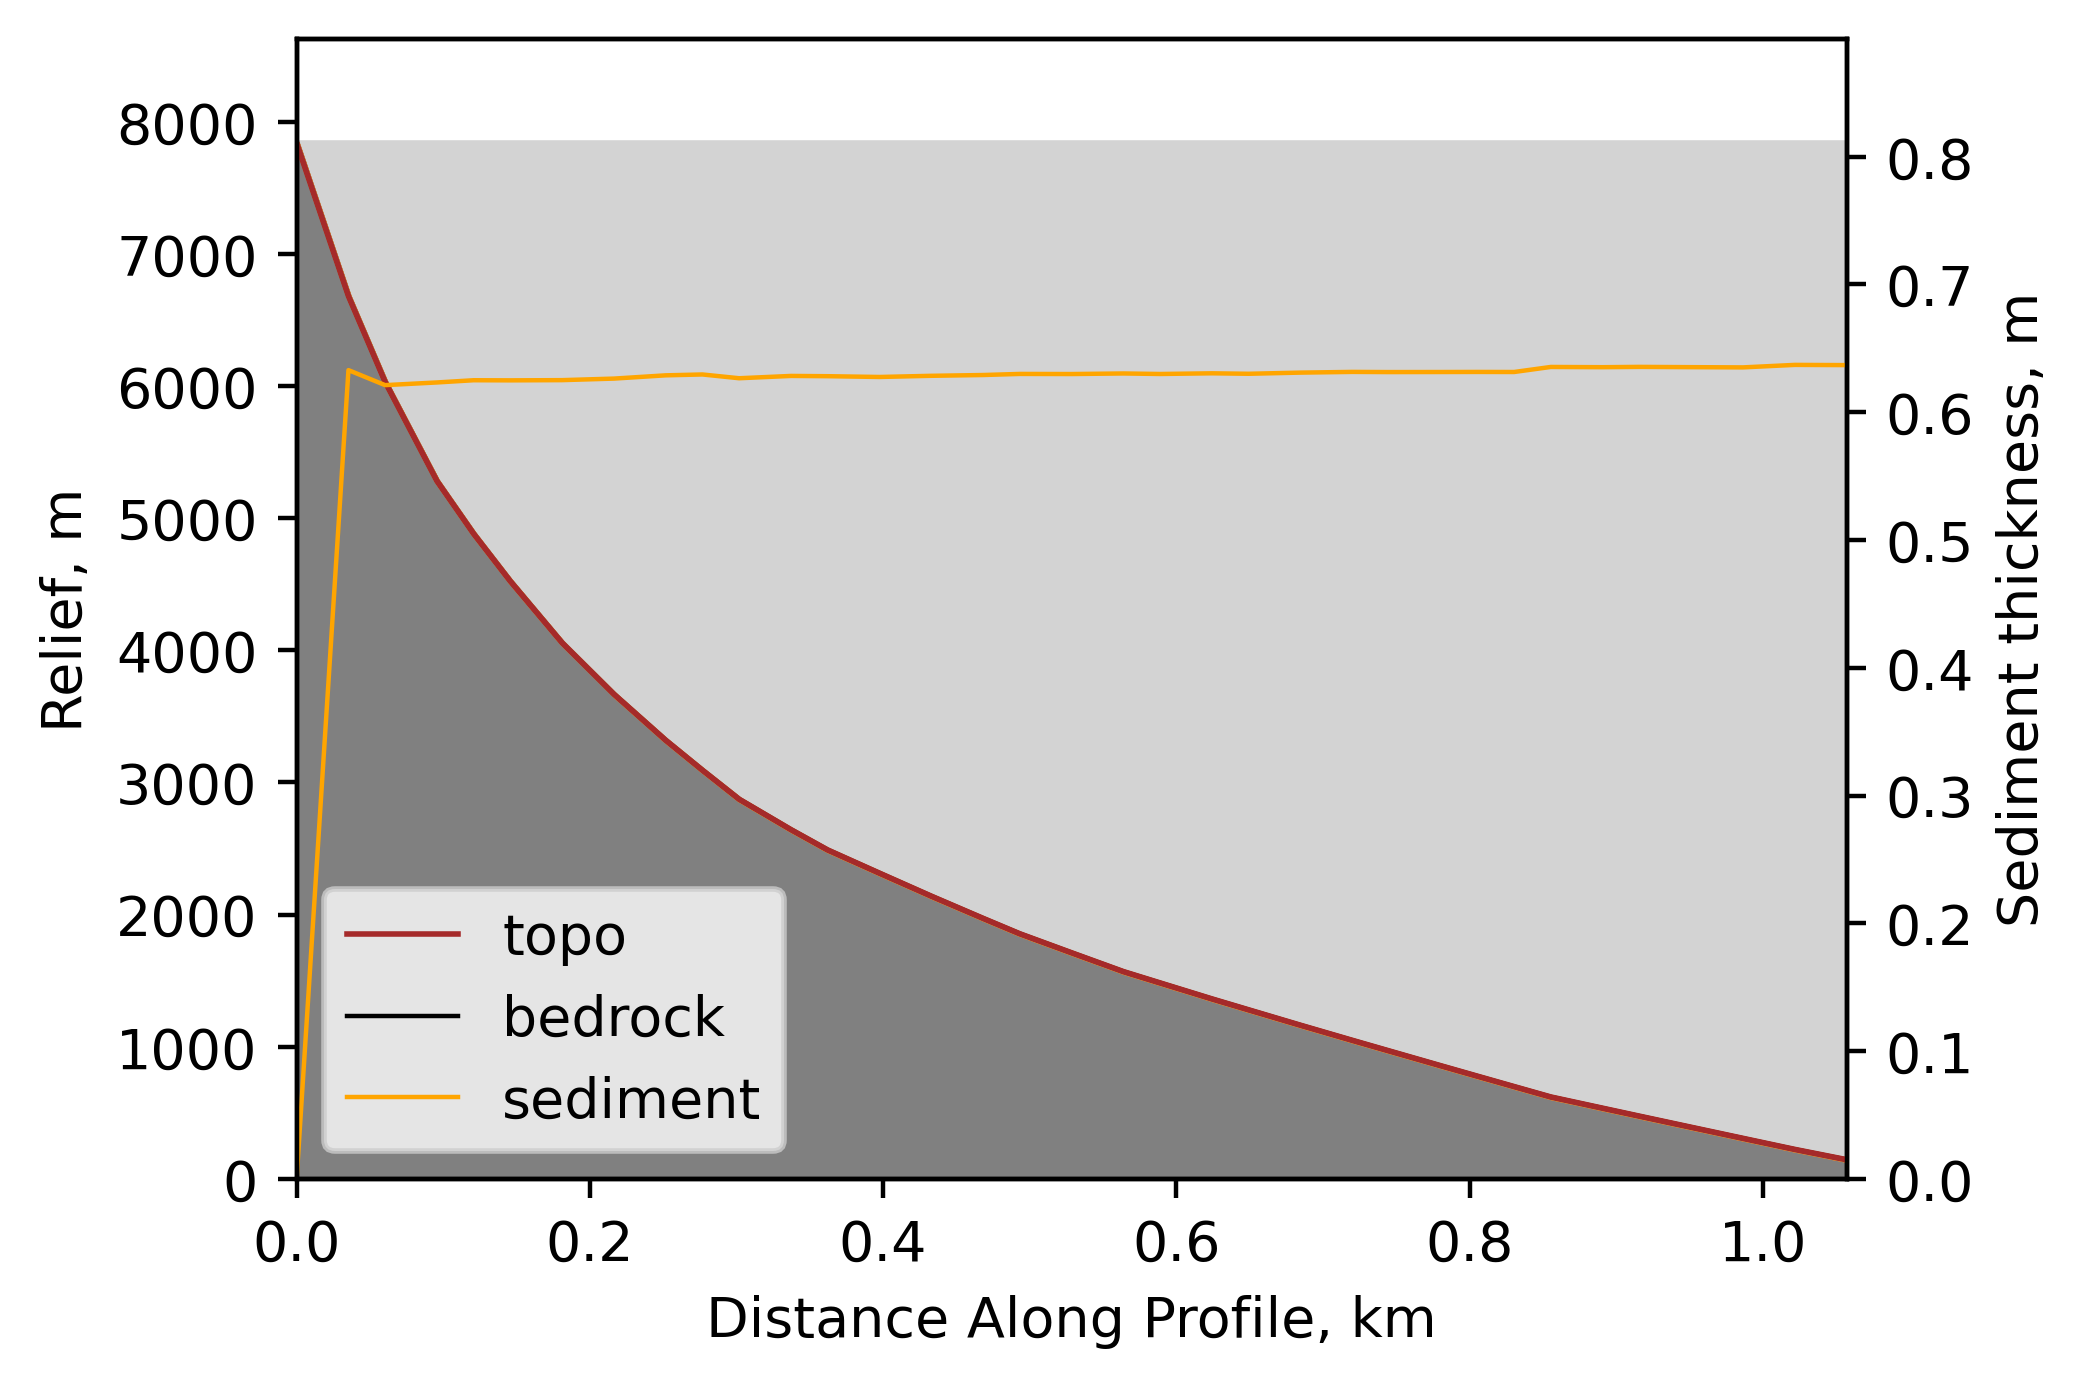

In [16]:
profiler = ChannelProfiler(mg)
profiler.run_one_step()
riv_nodes = profiler.nodes

mg.at_node["bedrock_elevation"]=mg.at_node["topographic__elevation"]-mg.at_node["soil__depth"]
dist_atNodes=profiler.distance_along_profile[0]

el = mg.at_node["topographic__elevation"][riv_nodes]
sd = mg.at_node["soil__depth"][riv_nodes]

br = el-sd     # Use ravel() to flatten el and br to 1D
el = el.ravel()
sd = sd.ravel()
br = br.ravel() # Calculate minimum elevation and relief

min_elevation = min(np.min(el), np.min(br), 0)
el_relief = el - min_elevation
br_relief = br - min_elevation

qs = mg.at_node["sediment__flux"][riv_nodes]
qs[np.where(qs<10)] = np.nanplt_fontsize =10     

fig, ax1 = plt.subplots(figsize=(5,3.7), dpi=400)
ax2 = ax1.twinx()

dist = (max(dist_atNodes)-dist_atNodes)*1e-3 
brown_c = [205/255,133/255,63/255] # Fill the entire area from max relief to 0

ax1.fill_between(dist, np.max(el_relief), 0, color='lightgrey', label='total area') # Fill the bedrock and colluvial material relief
ax1.fill_between(dist, br_relief, 0, color='grey', label='bedrock')
ax1.fill_between(dist, el_relief, br_relief, color=brown_c, label='colluvial material') # Plot bedrock and topographic relief

lns2 = ax1.plot(dist, br_relief, color='k', label='bedrock', linewidth=0.8, zorder=3)
lns1 = ax1.plot(dist, el_relief, color='brown', label='topo', linewidth=1, zorder=4) # set up labels

ax1.set_xlabel('Distance Along Profile, km', fontweight='normal', fontsize=10.0)
ax1.tick_params(labelsize=10.0)
ax1.set_ylabel('Relief, m', fontweight='normal', fontsize=10.0)
ax1.set_ylim((0, np.max(el_relief)*1.1))


# plot sediment thickness
lns3 = ax2.plot(dist, sd, color='orange', label ='sediment', linewidth=0.8)

ax2.set_ylabel('Sediment thickness, m', fontweight='normal', fontsize=10.0)
ax2.set_ylim((0, np.nanmax(sd)*1.4))
ax2.set_xlim((0, dist[2]))
ax2.tick_params(labelsize=10.0) # Merge legends

lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]

ax1.legend(lns, labs, fontsize=10.0) # Set y-axis to start from 0
ax1.set_ylim(bottom=0)

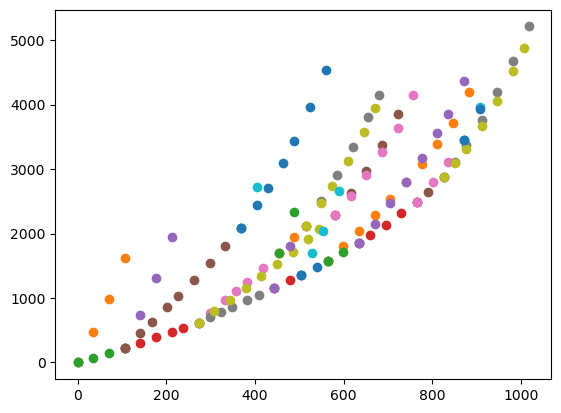

In [17]:
# channel profiles with sediment   ------- NiLAY added this, longer code ---------
dx = node_spacing
area_threshold = dx*dx*10.

profiler = ChannelProfiler(mg, number_of_watersheds=1, minimum_channel_threshold=area_threshold, main_channel_only=False)
profiler.run_one_step()

#plot channel profiles

outlets = list(profiler.data_structure.keys()) #outlets from channel profiler
for outlet in outlets: #cycle thru outlets
    segments = list(profiler.data_structure[outlet].keys()) #segments for that watershed
    #print(segments)
    for i, segment in enumerate(segments): #cycle thru segments
        ids = profiler.data_structure[outlet][segment]['ids'] #ids (index) of each segment
        distance = profiler.data_structure[outlet][segment]['distances']#distance downstream of each segment node
        eta = mg.at_node['topographic__elevation'][ids] #elevation of each segment node
        plt.scatter(distance,eta,alpha=1) #plot profile
        #plt.plot(distance,eta,color='green',alpha=1)   
plt.show()

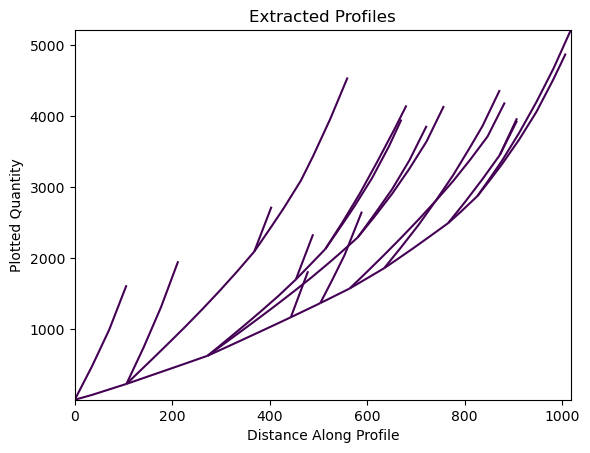

In [18]:
# VERY EASY WAY from methods/functions of the component:
profiler.plot_profiles()

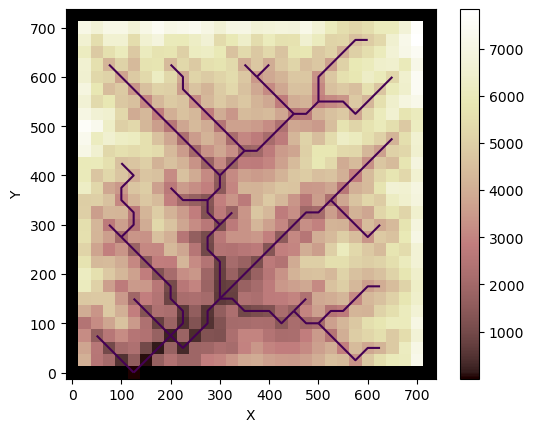

In [19]:
profiler.plot_profiles_in_map_view()

##### Sediment flux at the basin outlet after the landslide (Nilay?)

Here, we will visualize the sediment flux at the basin outlet and compare that to pre-landslide condition.

In [20]:
# CODE

<hr>

### STEP 3: See how landslide-derived sediments affect the evolution of downstream channels.
We run `GravelBedrockEroder` to simulate this effect through time

### Run GravelBedrockEroder (Need John's contribution)
Setup timestep, backgroup uplift rate, and flow routing. etc. and RUN

In [21]:
elev = mg.at_node["topographic__elevation"]

fa = FlowAccumulator(mg, runoff_rate=10.0)
fa.run_one_step()
eroder = GravelBedrockEroder(mg, abrasion_coefficient=0.0005,
                            coarse_fraction_from_plucking=0.1)
rock_elev = mg.at_node["bedrock__elevation"]
elev = mg.at_node["topographic__elevation"]
#years_forward = mg.add_zeros["years_in_future", at = "node"]
for i in range(20):
     rock_elev[mg.core_nodes] += 1e-2
     elev[mg.core_nodes] += 1e-2
     fa.run_one_step()
     chan_width = eroder.calc_implied_width(),
     eroder.calc_sediment_rate_of_change(),
     eroder.run_one_step(1.0)

FlowAccumulator found both the field 'water__unit_flux_in' and a provided float or array for the runoff_rate argument. THE FIELD IS BEING OVERWRITTEN WITH THE SUPPLIED RUNOFF_RATE!


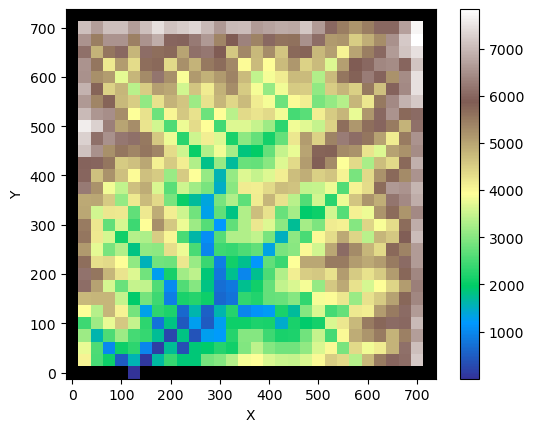

In [22]:
imshow_grid(mg, elev, cmap = "terrain")

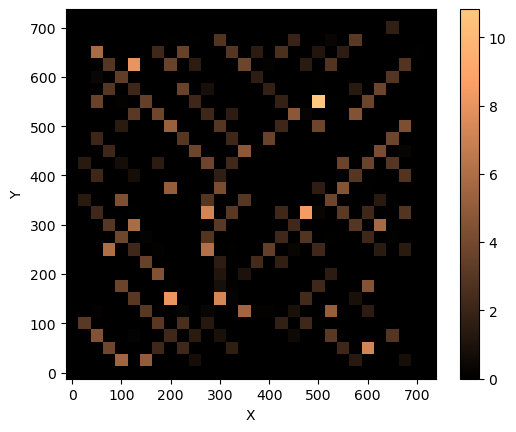

In [23]:
imshow_grid(mg, "soil__depth", cmap = "copper")

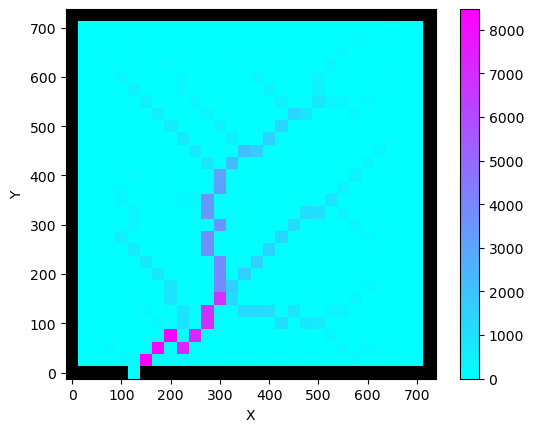

In [24]:
imshow_grid(mg, "sediment__flux", cmap = "cool")

In [25]:
imshow_grid(mg, chan_width,
            plot_name = "Channel Width", 
            cmap = "terrain")

AttributeError: 'tuple' object has no attribute 'size'

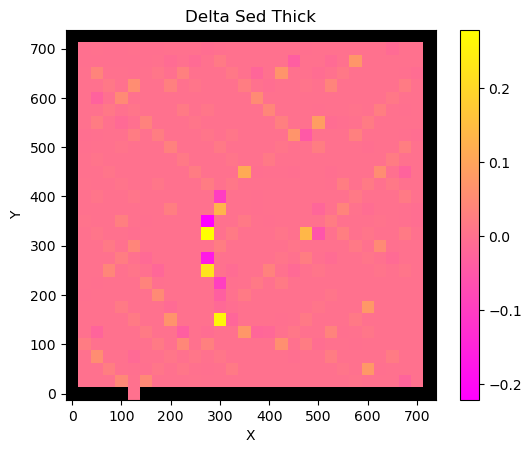

In [26]:
imshow_grid(mg, "sediment__rate_of_change",
            plot_name = "Delta Sed Thick", 
            cmap = "spring")

##### Plot post-Gravel Bedrock erosion landscape, soildepth, and plane-view river network etc (Yuan Li)

In [28]:
# Derive river network using ChannelProfiler
dx = node_spacing
area_threshold = dx*dx*10.
profiler = ChannelProfiler(mg, number_of_watersheds=1, minimum_channel_threshold=area_threshold, main_channel_only=False)
profiler.run_one_step()


####### Start plotting #######
plt_landscape_evo(profiler,mg)

ValueError: The number of watersheds requested by the ChannelProfiler is greater than the number in the domain with channel_definition_field area. [625.]

##### Plot river profile and other info for post-landslide landscape (Nilay)

In [ ]:
profiler = ChannelProfiler(mg)
profiler.run_one_step()
riv_nodes = profiler.nodes

mg.at_node["bedrock_elevation"]=mg.at_node["topographic__elevation"]-mg.at_node["soil__depth"]
dist_atNodes=profiler.distance_along_profile[0]

el = mg.at_node["topographic__elevation"][riv_nodes]
sd = mg.at_node["soil__depth"][riv_nodes]

br = el-sd     # Use ravel() to flatten el and br to 1D
el = el.ravel()
sd = sd.ravel()
br = br.ravel() # Calculate minimum elevation and relief

min_elevation = min(np.min(el), np.min(br), 0)
el_relief = el - min_elevation
br_relief = br - min_elevation

qs = mg.at_node["sediment__flux"][riv_nodes]
qs[np.where(qs<10)] = np.nanplt_fontsize =10     

fig, ax1 = plt.subplots(figsize=(5,3.7), dpi=400)
ax2 = ax1.twinx()

dist = (max(dist_atNodes)-dist_atNodes)*1e-3
brown_c = [205/255,133/255,63/255] # Fill the entire area from max relief to 0

ax1.fill_between(dist, np.max(el_relief), 0, color='lightgrey', label='total area') # Fill the bedrock and colluvial material relief
ax1.fill_between(dist, br_relief, 0, color='grey', label='bedrock')
ax1.fill_between(dist, el_relief, br_relief, color=brown_c, label='colluvial material') # Plot bedrock and topographic relief

lns2 = ax1.plot(dist, br_relief, color='k', label='bedrock', linewidth=0.8, zorder=3)
lns1 = ax1.plot(dist, el_relief, color='brown', label='topo', linewidth=1, zorder=4) # set up labels

ax1.set_xlabel('Distance Along Profile, km', fontweight='normal', fontsize=10.0)
ax1.tick_params(labelsize=10.0)
ax1.set_ylabel('Relief, m', fontweight='normal', fontsize=10.0)
ax1.set_ylim((0, np.max(el_relief)*1.1))


# plot sediment thickness
lns3 = ax2.plot(dist, sd, color='orange', label ='sediment', linewidth=0.8)

ax2.set_ylabel('Sediment thickness, m', fontweight='normal', fontsize=10.0)
ax2.set_ylim((0, np.nanmax(sd)*1.4))
ax2.set_xlim((0, dist[2]))
ax2.tick_params(labelsize=10.0) # Merge legends

lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]

ax1.legend(lns, labs, fontsize=10.0) # Set y-axis to start from 0
ax1.set_ylim(bottom=0)

<hr>

# Summary

### This notebook evaluates the impact of sediment pulses on gravel-bed river network evolution.

ESPIn 2024
More here...